In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import RDConfig, Draw
from IPython.core.display import HTML
from rdkit.Chem.Draw import rdMolDraw2D
from pathlib import Path 
from io import BytesIO
import joblib
import base64
import glob
import os

In [5]:
def mol_display(mol):
    '''function to draw multiple molecules'''
    d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    buffer = BytesIO(d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

# AiZynthFinder outputs - fragments

In [6]:
path = 'data/balanced_data'
files = Path(path).glob('*.csv') 

In [7]:
all_files = glob.glob(os.path.join(path , "*.csv"))
frames = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    frames.append(df)
df = pd.concat(frames, axis=0, ignore_index=True)

In [8]:
df = df.drop_duplicates(subset = 'target')

In [9]:
len(df)

20000

In [10]:
df = df[df.number_of_steps <= 10]
df = df[df.number_of_steps > 0]
len(df)

15918

<AxesSubplot:>

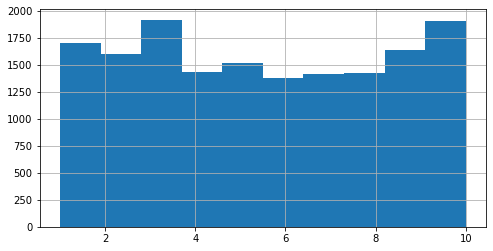

In [11]:
plt.figure(figsize=(8,4))
df.number_of_steps.hist() 

In [12]:
df['steps_bins'] = pd.cut(df['number_of_steps'], [0,1,3,6,10], labels=False) #, labels=False
df.steps_bins.value_counts()

3    6378
2    4324
1    3514
0    1702
Name: steps_bins, dtype: int64

In [63]:
all_mols = [Chem.MolFromSmiles(smile) for smile in df.target]
df['mol'] = all_mols

# Fragment analysis

In [14]:
# Analýza fragmentů 
## Klasifikační model - vstup fingerprint, vystup pocet kroku
### muzu trenovat rovnou na techto datech 
## zpetne se podivan na kterych bitech nejvice zaviselo rozdeleni a co je to za fragment

In [15]:
# !pip install shap

In [16]:
from rdkit.Chem import rdMolDescriptors, Draw, DataStructs
from rdkit.Chem.Draw import IPythonConsole
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, ConfusionMatrixDisplay
import xgboost
import shap
from IPython.display import display_html
from itertools import cycle

## Start

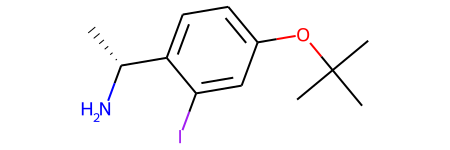

In [17]:
a = all_mols[0]
a

In [18]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(a, radius=2, bitInfo=bi)
# list(fp.GetOnBits())[:10]
# Draw.DrawMorganBit(a,list(fp.GetOnBits())[4],bi)

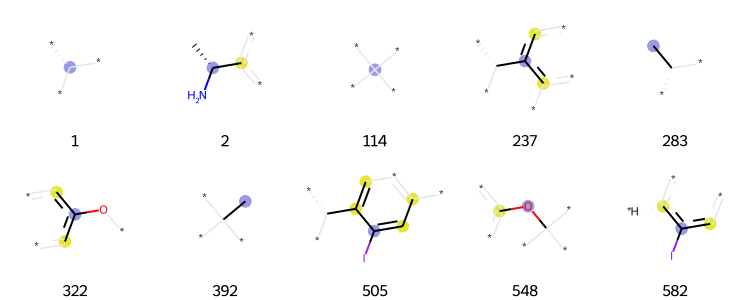

In [19]:
tpls = [(a,x,bi) for x in fp.GetOnBits()]
Draw.DrawMorganBits(tpls[:10],molsPerRow=5,legends=[str(x) for x in fp.GetOnBits()][:10])

## My data

In [20]:
#all_mols = [Chem.MolFromSmiles(smile) for smile in all_data.target]
#fingers = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in all_mols]
fingers = []
bi_all = []
for m in all_mols:
    bi_i = {}
    fing = Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024, bitInfo=bi_i)
    bi_all.append(bi_i)
    fingers.append(fing)

In [21]:
RFR = RandomForestRegressor(random_state=0)

In [22]:
y = np.array(df.steps_bins).ravel()
x = np.array(fingers)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [23]:
RFR.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [24]:
RFR_fit = RFR.fit(X_train, y_train)
predict = RFR_fit.predict(X_test)
predict_r = np.array([round(y) for y in predict])

In [25]:
print('f1: %0.3f' % f1_score(y_test, predict_r, average='weighted'))
print('Accuracy: %0.3f' % accuracy_score(y_test, predict_r))
print('Recall: %0.3f' % recall_score(y_test, predict_r, average='weighted'))
print('Precision: %0.3f' % precision_score(y_test, predict_r, average='weighted', zero_division=0))
print('MSE: %0.3f' %  mean_squared_error(y_test, predict))
print('MAE: %0.3f' % mean_absolute_error(y_test, predict))
print('R2: %0.3f' % r2_score(y_test, predict))

f1: 0.336
Accuracy: 0.373
Recall: 0.373
Precision: 0.548
MSE: 0.771
MAE: 0.730
R2: 0.261


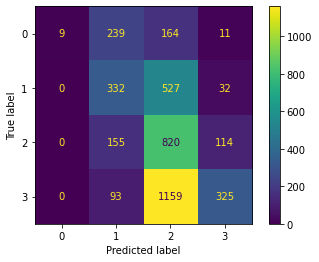

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, predict_r)
plt.show()

In [27]:
importances = RFR.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFR.estimators_], axis=0)
forest_importances = pd.Series(importances)

In [28]:
forest_importances = forest_importances.sort_values(ascending=False)

In [29]:
fi = forest_importances[:20]
fi

128     0.051586
314     0.027751
985     0.019505
147     0.010560
389     0.007449
798     0.006393
90      0.005942
893     0.005785
242     0.005756
456     0.005547
695     0.004955
739     0.004811
1019    0.004632
175     0.003900
656     0.003781
41      0.003776
5       0.003760
935     0.003729
4       0.003711
64      0.003701
dtype: float64

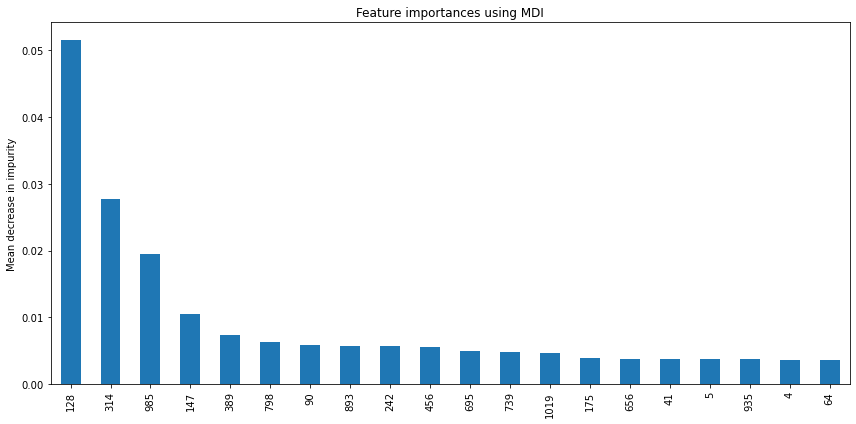

In [30]:
fig, ax = plt.subplots(figsize=(12,6))
fi.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI") #Feature importance based on mean decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [31]:
t = [128,314,985,147,389,798,90,893,242,456]
selected_features = t

In [64]:
def mol2fp(mol):
    bitInfo={}
    fp = Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr, bitInfo

def show_fragments(mol, selected_features):
    fp, bitinfo = mol2fp(mol)
    onbit = [bit for bit in bitinfo.keys()]
    importantonbits = sorted(list(set(onbit) & set(selected_features)))
    tpls = [(mol, x, bitinfo) for x in importantonbits]
    picture = Draw.DrawMorganBits(tpls,molsPerRow=4,subImgSize=(250,240),legends=[str(x) for x in importantonbits])
    return picture

def show_fragment(mol, frag):
    fp, bitinfo = mol2fp(mol)
    onbit = [bit for bit in bitinfo.keys()]
    picture = Draw.DrawMorganBit(mol, frag, bitinfo, useSVG=True)
    return picture

def fragment(frag, bi):
    for i in range(len(all_mols)):
        if frag in bi[i]:
            return i
        
def ids_fragment(key, bi): # return id of mol with fragment
    ids = []
    for i in range(len(bi)):
        if key in bi[i]:
            ids.append(i)
    return ids

def show_fragments_on_different_mols(selected_features, all_mols): # show fragments on mols where they are
    mols=[]
    for frag in selected_features:
        i = fragment(frag, bi_all)
        mols.append(all_mols[i])
    tpls = []
    for k in range(len(selected_features)):
        fp, bitinfo = mol2fp(mols[k])
        tpls.append((mols[k], selected_features[k], bitinfo))
    return Draw.DrawMorganBits(tpls,molsPerRow=4,subImgSize=(250,240),legends=[str(x) for x in selected_features])

#https://stackoverflow.com/questions/73316832/displaying-multiple-dataframes-together-in-formation
def display_in_matrix_form(*args, titles = cycle(['']), rows, columns):
    for i in range(0, rows):
        html_str=''
        row_args = args[i*columns:(i+1)*columns]
        row_titles = titles[i*columns:(i+1)*columns]
        for j in range(0, columns):
            html_str+='<th style="text-align:center"><td style="vertical-align:top">'
            html_str+=f'<h2 style="text-align: center;">{row_titles[j]}</h2>'
            html_str+=row_args[j].to_html().replace('table','table style="display:inline"')
            html_str+='</td></th>'
        display_html(html_str,raw=True)
        
def show_fragments_on_different_mols_pandas(selected_features): # show fragments on mols where they are
    mols=[]
    for frag in selected_features:
        i = fragment(frag, bi_all)
        mols.append(all_mols[i])
    tpls = []
    for k in range(len(selected_features)):
        fp, bitinfo = mol2fp(mols[k])
        tpls.append((mols[k], selected_features.iloc[k], bitinfo))
    return Draw.DrawMorganBits(tpls,molsPerRow=4,subImgSize=(250,240),legends=[str(x) for x in selected_features])

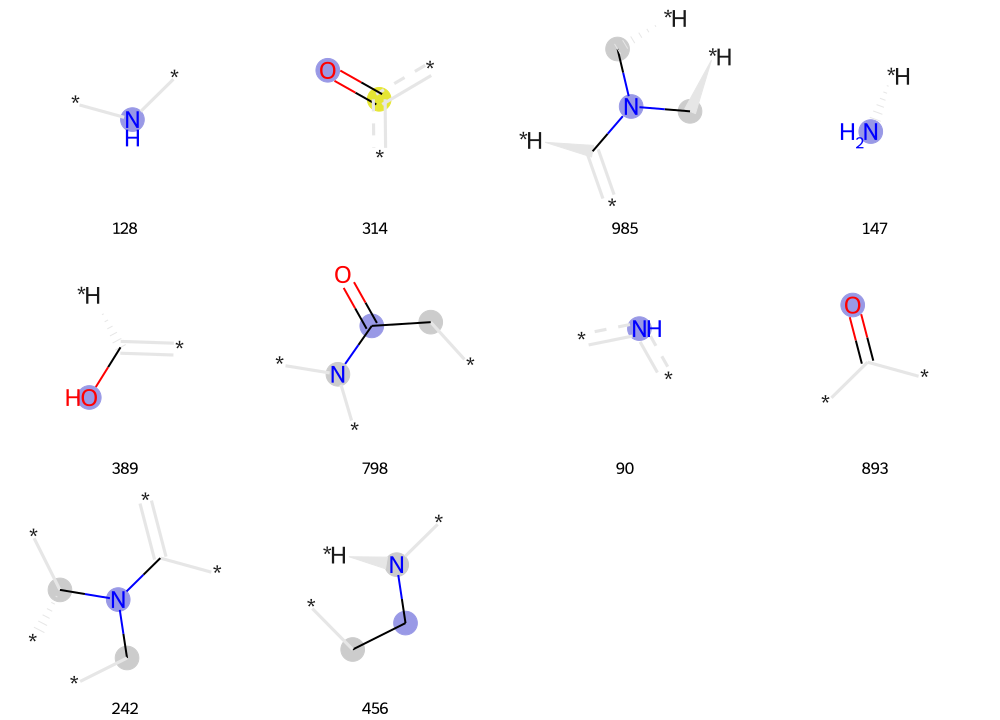

In [33]:
show_fragments_on_different_mols(selected_features)

In [34]:
i = 0
frags = []
lens = []
while i < len(all_mols):
    fs = []
    for f in selected_features:
        if f in bi_all[i]:
            fs.append(f)
    i = i + 1
    frags.append(fs)
    lens.append(len(fs))

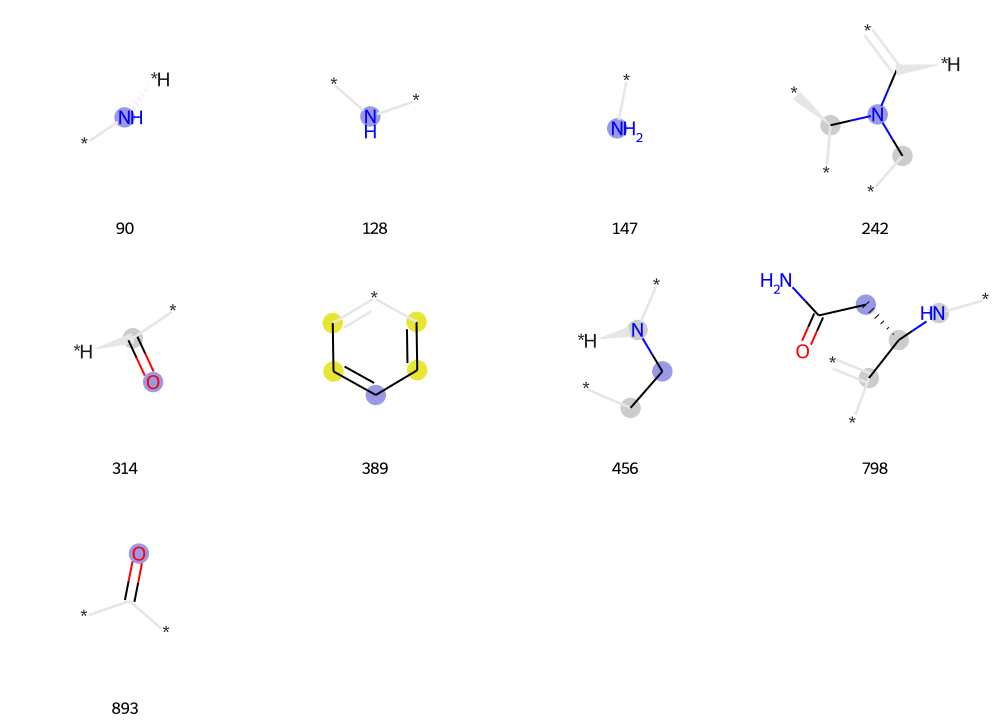

In [35]:
show_fragments(all_mols[lens.index(max(lens))], frags[lens.index(max(lens))])

In [36]:
ids = ids_fragment(36, bi_all)
ids[:10]

[5, 6, 27, 35, 42, 43, 50, 52, 57, 67]

In [37]:
model = RandomForestRegressor().fit(x, y) 
explainer = shap.Explainer(model, x)

100%|===================| 15903/15918 [17:03<00:00]        

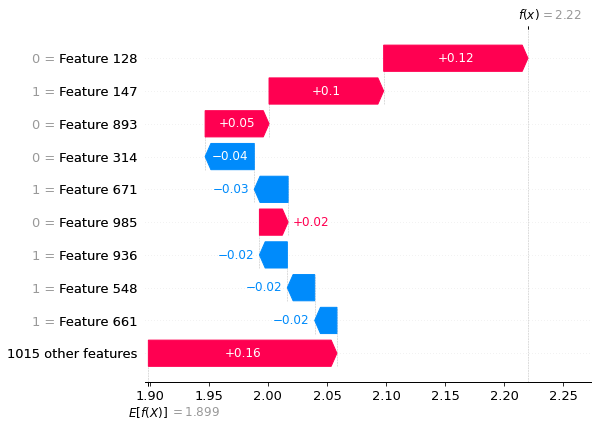

In [38]:
shap_values = explainer(x)
shap.waterfall_plot(shap_values[0])

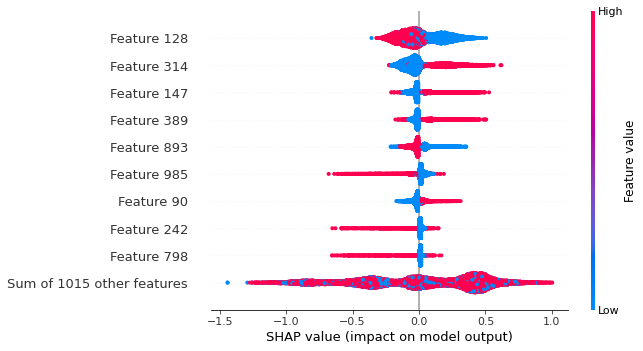

In [39]:
shap.plots.beeswarm(shap_values)

Bit Info - the keys are the bit ids, the values are lists of (atom index, radius) tuples.

# The difference in bins

In [158]:
dataframes = []
for i in range(len(df)):
    b = df.steps_bins.iloc[i]
    data = {'group': b, 'frag':bi_all[i].keys()}
    d = pd.DataFrame(data)
    dataframes.append(d)

In [159]:
data = pd.concat(dataframes)
data = data.reset_index(drop=True)

In [54]:
value_count = data['frag'].value_counts()
count_frag = pd.DataFrame(value_count)
count_frag = count_frag.reset_index()
count_frag = count_frag.rename(columns={"frag": "count", 'index':'frag'})

In [55]:
count_frag["prob"] = count_frag["count"].apply(lambda x: float(x)/len(data))
count_frag.head(5)

,frag,count,prob
0,356,14108,0.017762
1,33,13460,0.016946
2,650,13302,0.016747
3,849,13289,0.016731
4,807,12885,0.016222


In [56]:
df0 = data[data.group == 0]
df1 = data[data.group == 1]
df2 = data[data.group == 2]
df3 = data[data.group == 3]

In [57]:
value_count0 = df0['frag'].value_counts()
count_frag0 = pd.DataFrame(value_count0)
count_frag0 = count_frag0.reset_index()
count_frag0 = count_frag0.rename(columns={"frag": "count", 'index':'frag'})
count_frag0["prob"] = count_frag0["count"].apply(lambda x: float(x)/len(df0))

value_count1 = df1['frag'].value_counts()
count_frag1 = pd.DataFrame(value_count1)
count_frag1 = count_frag1.reset_index()
count_frag1 = count_frag1.rename(columns={"frag": "count", 'index':'frag'})
count_frag1["prob"] = count_frag1["count"].apply(lambda x: float(x)/len(df1))

value_count2 = df2['frag'].value_counts()
count_frag2 = pd.DataFrame(value_count2)
count_frag2 = count_frag2.reset_index()
count_frag2 = count_frag2.rename(columns={"frag": "count", 'index':'frag'})
count_frag2["prob"] = count_frag2["count"].apply(lambda x: float(x)/len(df2))

value_count3 = df3['frag'].value_counts()
count_frag3 = pd.DataFrame(value_count3)
count_frag3 = count_frag3.reset_index()
count_frag3 = count_frag3.rename(columns={"frag": "count", 'index':'frag'})
count_frag3["prob"] = count_frag3["count"].apply(lambda x: float(x)/len(df3))

In [58]:
display_in_matrix_form(count_frag0[:10],count_frag1[:10],count_frag2[:10],count_frag3[:10], 
                       titles=['Group 0','Group 1', 'Group 2', 'Group 3'], rows = 1, columns = 4) 

,frag,count,prob
0,807,1519,0.019268
1,650,1502,0.019053
2,356,1459,0.018507
3,33,1440,0.018266
4,893,1411,0.017898
5,849,1391,0.017645
6,926,1375,0.017442
7,128,1339,0.016985
8,80,1272,0.016135
9,1019,1236,0.015679


In [78]:
inter_frags = [807, 650, 356, 893, 849, 128, 1019, 726]

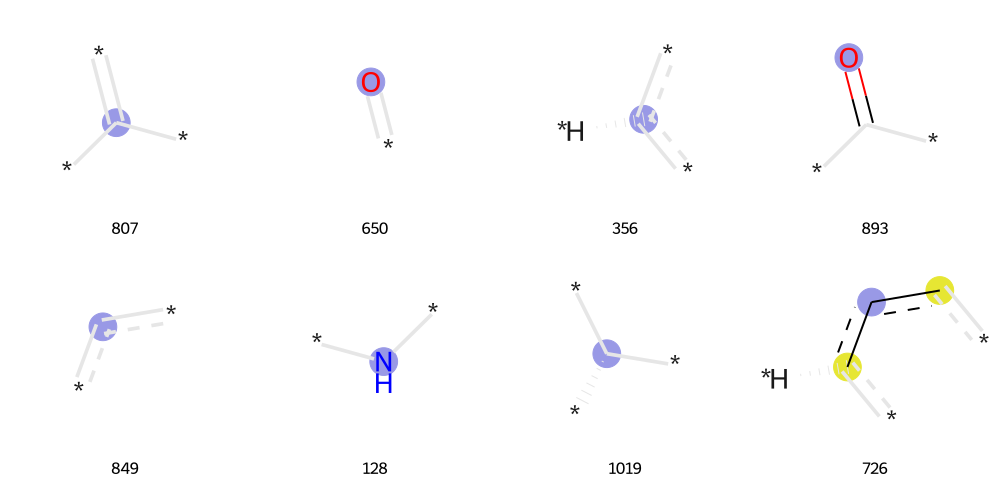

In [79]:
show_fragments_on_different_mols(inter_frags, all_mols)

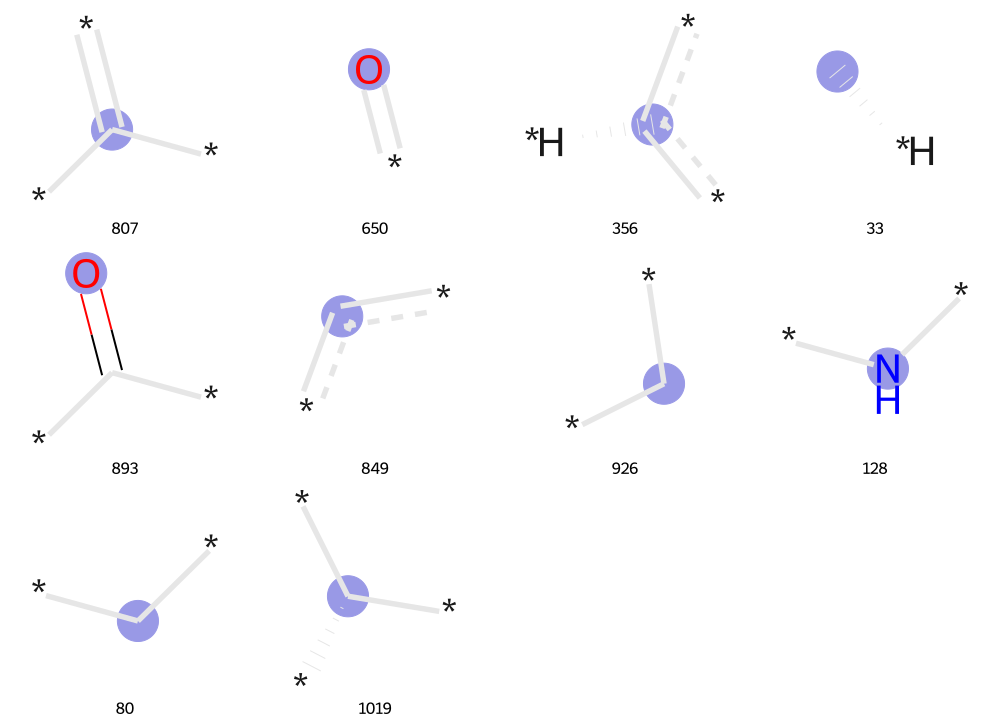

In [67]:
show_fragments_on_different_mols(count_frag0.frag[:10], all_mols)

# Unique fragments

In [80]:
count_frag0['group'] = 0
count_frag1['group'] = 1
count_frag2['group'] = 2
count_frag3['group'] = 3

In [81]:
count_frag0.head()

,frag,count,prob,group
0,807,1519,0.019268,0
1,650,1502,0.019053,0
2,356,1459,0.018507,0
3,33,1440,0.018266,0
4,893,1411,0.017898,0


In [82]:
frames = [count_frag0, count_frag1, count_frag2, count_frag3]
data = pd.concat(frames)
data = data.reset_index(drop=True)

In [83]:
data = data.drop_duplicates(subset=['frag'], keep=False)
#data = data.sort_values(by=['count'], ascending=False)
len(data)

0

# Ratio of probabilities

## Group 0 vs 1

In [84]:
merge = count_frag0.merge(count_frag1, left_on='frag', right_on='frag')
merge["prob_ratio"] = merge['prob_x'] / merge['prob_y'] 
merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)

In [85]:
merge.head()

,frag,count_x,prob_x,group_x,count_y,prob_y,group_y,prob_ratio
588,353,33,0.000419,0,32,0.000189,1,2.212568
577,962,33,0.000419,0,35,0.000207,1,2.022920
560,326,34,0.000431,0,39,0.000231,1,1.870454
362,95,49,0.000622,0,57,0.000337,1,1.844395
396,347,46,0.000584,0,55,0.000325,1,1.794436


In [87]:
display_in_matrix_form(merge[['frag','prob_ratio','count_x','count_y']].head(10), 
                       merge[['frag','prob_ratio','count_y','count_x']].tail(10),
                       titles=['More often in group 0','More often in group 1'], rows = 1, columns = 2) 

,frag,prob_ratio,count_x,count_y
588,353,2.212568,33,32
577,962,2.022920,33,35
560,326,1.870454,34,39
362,95,1.844395,49,57
396,347,1.794436,46,55
745,100,1.787934,25,30
686,704,1.716417,28,35
884,572,1.698537,19,24
126,994,1.689027,111,141
957,450,1.668739,14,18


In [86]:
len(merge), len(count_frag0), len(count_frag1)

(1024, 1024, 1024)

In [88]:
#frames = [count_frag0, count_frag1]
#d = pd.concat(frames)
#d = d.drop_duplicates(subset=['frag'], keep=False)
#d = d.reset_index(drop=True)
#d = d.sort_values(by=['count'], ascending=False)

In [91]:
#display_in_matrix_form(d[d.group == 0], d[d.group == 1], titles=['Only group 0','Only group 1'], rows = 1, columns = 2) 

In [93]:
#show_fragments_on_different_mols_pandas(d[d.group == 0].frag)

In [94]:
#show_fragments_on_different_mols_pandas(d[d.group == 1].frag)

## Group 1 vs 2

In [96]:
merge = count_frag1.merge(count_frag2, left_on='frag', right_on='frag')
merge["prob_ratio"] = merge['prob_x'] / merge['prob_y'] 
merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)

In [97]:
len(merge), len(count_frag1), len(count_frag2)

(1024, 1024, 1024)

In [98]:
display_in_matrix_form(merge[['frag','prob_ratio','count_x','count_y']].head(10), 
                       merge[['frag','prob_ratio','count_y','count_x']].tail(10),
                       titles=['More often in group 1','More often in group 2'], rows = 1, columns = 2) 

,frag,prob_ratio,count_x,count_y
131,218,2.568802,235,118
75,965,2.416802,356,190
150,882,2.085122,215,133
185,655,2.048611,189,119
144,603,1.996642,226,146
31,985,1.780379,686,497
186,868,1.770036,188,137
227,716,1.719822,164,123
493,107,1.713104,85,64
26,197,1.700278,783,594


## Group 2 vs 3

In [101]:
merge = count_frag2.merge(count_frag3, left_on='frag', right_on='frag')
merge["prob_ratio"] = merge['prob_x'] / merge['prob_y'] 
merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)

In [102]:
len(merge), len(count_frag2), len(count_frag3)

(1024, 1024, 1024)

In [103]:
display_in_matrix_form(merge[['frag','prob_ratio','count_x','count_y']].head(10), 
                       merge[['frag','prob_ratio','count_y','count_x']].tail(10),
                       titles=['More often in group 2','More often in group 3'], rows = 1, columns = 2) 

,frag,prob_ratio,count_x,count_y
618,517,1.757753,97,83
120,602,1.694788,311,276
573,651,1.664063,104,94
868,963,1.623426,68,63
662,643,1.608991,92,86
543,778,1.577069,108,103
809,746,1.566726,75,72
698,856,1.557773,87,84
942,6,1.556830,59,57
684,167,1.538633,89,87


## Group 0 vs 3

In [104]:
merge = count_frag0.merge(count_frag3, left_on='frag', right_on='frag')
merge["prob_ratio"] = merge['prob_x'] / merge['prob_y'] 
merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)

In [105]:
len(merge), len(count_frag0), len(count_frag3)

(1024, 1024, 1024)

In [113]:
display_in_matrix_form(merge[['frag','prob_ratio','prob_x','count_x','count_y','prob_y']].head(20), 
                       merge[['frag','prob_ratio','prob_y','count_y','count_x','prob_x']].tail(20),
                       titles=['More often in group 0','More often in group 3'], rows = 1, columns = 2) 

,frag,prob_ratio,prob_x,count_x,count_y,prob_y
81,186,2.688203,0.001966,155,240,0.000731
126,994,2.655311,0.001408,111,174,0.000530
34,985,2.644134,0.003932,310,488,0.001487
62,242,2.549457,0.002486,196,320,0.000975
85,480,2.497428,0.001865,147,245,0.000747
31,387,2.434599,0.004326,341,583,0.001777
72,379,2.378502,0.002182,172,301,0.000917
322,359,2.365984,0.000685,54,95,0.000290
23,197,2.357148,0.005201,410,724,0.002206
32,117,2.287617,0.004287,338,615,0.001874


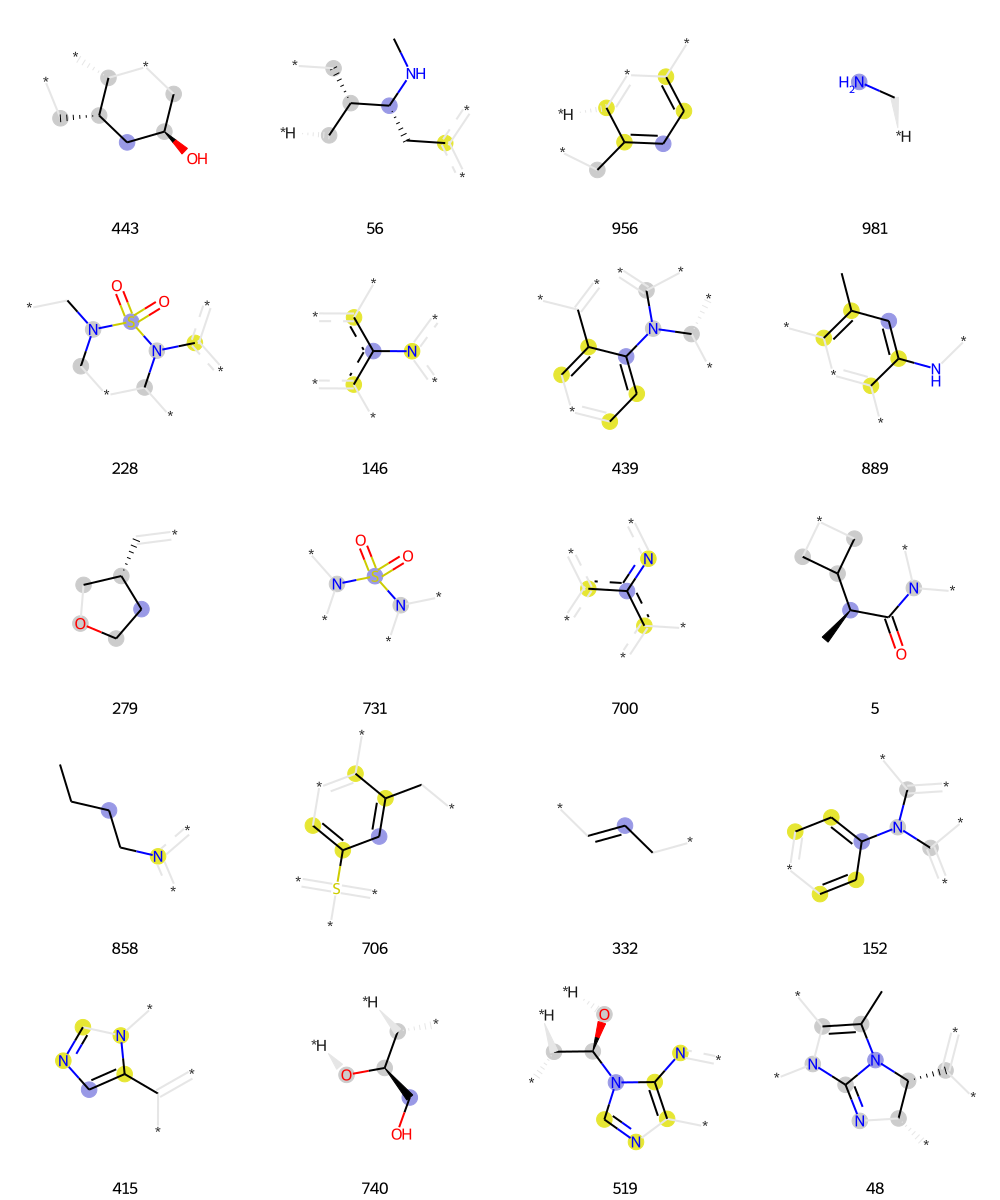

In [119]:
show_fragments_on_different_mols_pandas(merge.frag.tail(20))